### late-stage diversification, sp3 acid with sp3 amine

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolDrawing, DrawingOptions, MolToImage

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import numpy as np
import pandas as pd
import os

from tqdm.notebook import tqdm
import multiprocessing as mp

import coupling_utils
import molprops_utils

### we tag the alpha and beta carbons as isotopes, for more precise matching

In [2]:
acid_smiles = "O=C(O)C1[C@@]2(C)CC[C@H]3[C@@H](CC[C@H]4NC(C=C[C@]34CF)=O)[C@@H]2CC1"

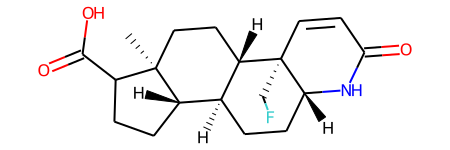

In [3]:
acid = Chem.MolFromSmiles(acid_smiles)
acid

In [4]:
amine_smiles = "NC(C)(CF)C"

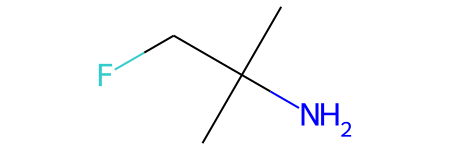

In [5]:
amine = Chem.MolFromSmiles(amine_smiles)
amine

In [6]:
am2 = Chem.MolFromSmarts("[CX3]=[CX3][NH2]")
ac2 = Chem.MolFromSmarts("[CX3]=[CX3][CX3](=O)[OX2H1]")
am3 = Chem.MolFromSmarts("CC[NH2]")
ac3 = Chem.MolFromSmarts("[CX4H2][CX4H1][CX3](=O)O")


group_dict = {"ac2":ac2, "ac3":ac3,"am2":am2,"am3":am3}

# make a mapping dictionary.
# the dictionary is basically, first entry is amine C1. second entry is amine C2. 
# this changes depending on the matrix, and how the smarts for the matcher is written. 

# number of entries in the amat
amat_indices = range(8)
# which entry each index should map to
mapping_order = [0,1,3,4,5,2,6,7]
# mapping_order = [3,4,5,0,1,2,6,7]

# amat index -> amine/acid match index
amat2ind = {k:v for k,v in zip(amat_indices, mapping_order)}
ind2amat = {v:k for k,v in zip(amat_indices, mapping_order)}

bond_dict = {1:Chem.BondType.SINGLE, 2:Chem.BondType.DOUBLE, 3:Chem.BondType.TRIPLE}

### check that the substruct matching hits the right region

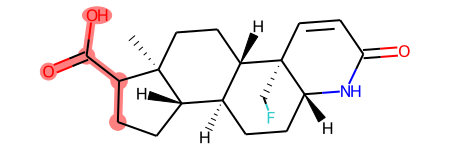

In [7]:
acid.GetSubstructMatch(ac3)
acid

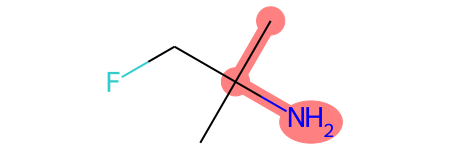

In [8]:
amine.GetSubstructMatch(am3)
amine

In [9]:
both = Chem.CombineMols(acid,amine)
Chem.Kekulize(both,clearAromaticFlags=True)

In [10]:
# get the indices for the acid and amine matches.

acid_atoms = both.GetSubstructMatch(group_dict["ac3"])
amine_atoms = both.GetSubstructMatch(group_dict["am3"])

In [11]:
atom_list = amine_atoms + acid_atoms

starting_numHs = np.zeros(8)
for i_at, atom_ind in enumerate(atom_list):
    a = both.GetAtomWithIdx(atom_ind)
    
    print(a.GetSymbol(),a.GetTotalNumHs())
    starting_numHs[ind2amat[i_at]]=int(a.GetTotalNumHs())

C 3
C 0
N 2
C 2
C 1
C 0
O 0
O 1


In [12]:
starting_numHs

array([3., 0., 2., 1., 0., 2., 0., 1.])

### the product matrices and product distances need to be computed before the code below is run.

In [13]:
for p in ["./finasteride_products/side1","./finasteride_products/side2"]:
    if not os.path.exists(p):
        os.makedirs(p)

In [14]:
map_input = [[i,acid,amine,starting_numHs,1] for i in range(56)]

In [15]:
if __name__ == '__main__':
    with mp.Pool(24) as p:
        result = p.starmap(coupling_utils.run_enumeration, map_input,chunksize=1)

### processing

In [17]:
def count_atoms(s):
    alphab = "CONcon"
    return len([i for i in s if i in alphab])     

def check_smiles(s):
    # just check for F
    
    coupled_smiles = []
    split_smiles = s.split(".")

    for ss in split_smiles:
        if (ss.count("F") == 2):
            coupled_smiles.append(ss)
    if len(coupled_smiles) == 0:
        return "C"
    
    else:
        atom_counts = [count_atoms(s) for s in coupled_smiles]
        largest_frag_ind = np.argmax(atom_counts)
        return coupled_smiles[largest_frag_ind]

In [18]:
all_coupling_data = []

for file_ind in tqdm(range(56)):
    
    file_tag = str(file_ind).zfill(2)
    
    distance_data = pd.read_csv(f"../data_files/smiles_with_all_dists/smiles_with_all_dists_{file_tag}.csv")
    coupling_data = pd.read_csv(f"./finasteride_products/side1/finasteride_side1_{file_tag}.csv")

    raw_tags = list(coupling_data.rmat_tag - file_ind*1000000)
    coupling_dists = list(distance_data.iloc[raw_tags].ac3_am3)

    coupling_data["distance"] = coupling_dists


    largest_frag = []
    for s in coupling_data.pdt_smiles:
        largest_frag.append(check_smiles(s))
    coupling_data["largest_frag"] = largest_frag
    
    # remove duplicates
    coupling_data.sort_values("distance",inplace=True)
    coupling_data.drop_duplicates(subset="largest_frag",inplace=True)
    coupling_data.sort_values("rmat_tag",inplace=True)


    all_coupling_data.append(coupling_data)

  0%|          | 0/56 [00:00<?, ?it/s]

In [19]:
def clean_smiles(s):
    repl = {"F":"","()":""}
    
    temp = s[:]
    
    for rep in repl:
        temp = temp.replace(rep,repl[rep])
        
    return temp
    

In [20]:
# sort by increasing distance first
all_coupling_df = pd.concat(all_coupling_data)
all_coupling_df.sort_values("distance",inplace=True)
largest_cleaned = [clean_smiles(s) for s in all_coupling_df.largest_frag]
all_coupling_df["largest_cleaned"] = largest_cleaned

# de-duplicate, keeping the one with the lowest coupling distance. 
all_coupling_df.drop_duplicates(subset="largest_cleaned",inplace=True)
all_coupling_df.sort_values("rmat_tag",inplace=True)

all_coupling_df = all_coupling_df[all_coupling_df.largest_frag!="C"].copy()

In [21]:
if __name__ == '__main__':
    with mp.Pool(8) as p:
        bredt_check = p.map(molprops_utils.check_bredt, all_coupling_df.largest_cleaned,chunksize=100)

In [22]:
all_coupling_df["bredt"] = bredt_check
all_coupling_df_bredt = all_coupling_df[all_coupling_df.bredt].copy()
all_coupling_df_bredt.reset_index(drop=True,inplace=True)

In [23]:
all_coupling_df_bredt["structure_tag"] = [f"{i}_S1" for i in all_coupling_df_bredt.rmat_tag]

In [24]:
all_coupling_df_bredt.head()

,rmat_tag,pdt_smiles,distance,largest_frag,largest_cleaned,bredt,structure_tag
0,40932,C.C=O.CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]2...,7.0,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23CF)[C...,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23C)[C@...,True,40932_S1
1,40947,C.C.CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23C...,10.0,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23CF)[C...,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23C)[C@...,True,40947_S1
2,40955,C.CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23CF)...,7.0,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23CF)[C...,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23C)[C@...,True,40955_S1
3,40962,C.CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23CF)...,10.0,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23CF)[C...,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23C)[C@...,True,40962_S1
4,40964,C.CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23CF)...,10.0,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23CF)[C...,CC1CC[C@H]2[C@@H](CC[C@H]3NC(=O)C=C[C@]23C)[C@...,True,40964_S1


In [25]:
all_coupling_df_bredt[["structure_tag","distance","largest_cleaned"]].to_csv("./finasteride_products/cleaned_side1.csv",index=False)